# Black–Scholes Implied Volatility Surface
This notebook walks through the complete workflow of loading option quotes, computing Black–Scholes implied volatilities, reshaping them into a surface, and visualizing the results. Each step is self-contained and heavily commented so it can serve as both documentation and a reusable analysis template.

## 1. Imports and global configuration

In [16]:
%matplotlib inline

# Core scientific stack
import math
from math import exp, log, sqrt

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection side effects)
from scipy.optimize import brentq

# Global plotting and display parameters
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = lambda x: f"{x:,.6f}"

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load option CSV

In [17]:
# Path to the CSV sitting next to this notebook. Adjust if your data lives elsewhere.
CSV_PATH = "options_sample_200.csv"

# Read the dataset and perform quick sanity checks.
df = pd.read_csv(CSV_PATH)
expected_cols = {"S0", "K", "C_mkt", "T"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing required columns: {missing}")

print(f"Loaded {CSV_PATH} with shape {df.shape}.")
display(df.head())
print("Descriptive statistics:")
display(df.describe(include='all'))

Loaded options_sample_200.csv with shape (200, 4).


,S0,K,C_mkt,T
0,154.470400,186.353300,3.537055,0.492360
1,132.697200,112.878500,26.873141,0.875058
2,197.114600,171.723000,38.214198,0.987817
3,108.817600,124.428100,11.234760,1.471647
4,115.785800,178.752900,2.846713,0.826186


Descriptive statistics:


,S0,K,C_mkt,T
count,200.000000,200.000000,200.000000,200.000000
mean,124.486504,131.675474,16.582959,1.004357
std,43.745069,59.153083,13.544509,0.569915
min,50.831800,39.780700,0.000107,0.050160
25%,86.122250,84.906025,6.868489,0.518659
50%,124.664150,118.011050,12.971043,0.977830
75%,160.151725,176.452625,22.680270,1.483037
max,199.837800,315.952600,64.536586,1.992368


## 3. Black–Scholes helper functions

In [18]:
# --- Normal CDF -------------------------------------------------------
def normal_cdf(x: float) -> float:
    """Return Phi(x), the standard normal cumulative distribution function."""
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


# --- Black-Scholes call price ----------------------------------------
def bs_call(S0: float, K: float, T: float, r: float, q: float, vol: float) -> float:
    """Price a European call with the classic Black-Scholes closed form."""
    if T <= 0:
        # At expiry we fall back to intrinsic value discounted appropriately.
        return max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    vol = max(vol, 1e-10)  # Numerical guard to avoid division by zero.
    sqrt_T = math.sqrt(T)
    d1 = (math.log(S0 / K) + (r - q + 0.5 * vol * vol) * T) / (vol * sqrt_T)
    d2 = d1 - vol * sqrt_T
    discount_domestic = math.exp(-r * T)
    discount_foreign = math.exp(-q * T)
    price = S0 * discount_foreign * normal_cdf(d1) - K * discount_domestic * normal_cdf(d2)
    return price


# --- Implied volatility solver ---------------------------------------
def implied_vol_bs(C_mkt: float, S0: float, K: float, T: float, r: float, q: float = 0.0) -> float:
    """Invert the Black-Scholes formula via a safeguarded Brent search."""
    # Guardrails: handle degenerate maturities or absurd prices early.
    if T <= 0 or C_mkt <= 0:
        return float("nan")

    # Intrinsic value bound: if the market price violates it, exit gracefully.
    intrinsic = max(S0 * math.exp(-q * T) - K * math.exp(-r * T), 0.0)
    if C_mkt < intrinsic - 1e-8:
        return float("nan")

    # Objective for root finding: price(vol) - market price.
    def objective(vol: float) -> float:
        return bs_call(S0, K, T, r, q, vol) - C_mkt

    vol_low, vol_high = 1e-4, 0.5  # Sensible starting bracket.
    price_high = bs_call(S0, K, T, r, q, vol_high)
    # Expand the upper bracket until we dominate the market price or hit a cap.
    while price_high < C_mkt and vol_high < 10.0:
        vol_high *= 2.0
        price_high = bs_call(S0, K, T, r, q, vol_high)

    if price_high < C_mkt:
        return float("nan")

    try:
        return brentq(objective, vol_low, vol_high, xtol=1e-8, rtol=1e-8, maxiter=200)
    except ValueError:
        return float("nan")

## 4. Compute implied volatility column

In [19]:
# Constant short rate used throughout the analysis. Adjust here if needed.
risk_free_rate = 0.02
dividend_yield = 0.0

sigmas = []
for idx, row in df.iterrows():
    sigma = implied_vol_bs(row["C_mkt"], row["S0"], row["K"], row["T"], risk_free_rate, dividend_yield)
    sigmas.append(sigma)

df["sigma_BS"] = sigmas
print("Implied volatilities computed.")
display(df.head())

print("Sigma summary statistics:")
display(df["sigma_BS"].describe())

print("Missing values per column (post-sigma computation):")
display(df.isna().sum())

Implied volatilities computed.


,S0,K,C_mkt,T,sigma_BS
0,154.470400,186.353300,3.537055,0.492360,0.287776
1,132.697200,112.878500,26.873141,0.875058,0.292741
2,197.114600,171.723000,38.214198,0.987817,0.287900
3,108.817600,124.428100,11.234760,1.471647,0.299706
4,115.785800,178.752900,2.846713,0.826186,0.386529


Sigma summary statistics:


count   200.000000
mean      0.302128
std       0.047803
min       0.194467
25%       0.265512
50%       0.298364
75%       0.337638
max       0.441906
Name: sigma_BS, dtype: float64

Missing values per column (post-sigma computation):


S0          0
K           0
C_mkt       0
T           0
sigma_BS    0
dtype: int64

## 5. Reshape into surface grids

In [20]:
# Compute moneyness S0/K for each quote.
df["moneyness"] = df["S0"] / df["K"]

# Sorted grids for strikes, maturities, and moneyness.
K_grid = np.sort(df["K"].unique())
T_grid = np.sort(df["T"].unique())
m_grid = np.sort(df["moneyness"].unique())

# Pivot tables for different visualizations.
sigma_surface_m = df.pivot_table(index="T", columns="moneyness", values="sigma_BS")
sigma_surface_k = df.pivot_table(index="T", columns="K", values="sigma_BS")

print("Surface matrix (rows = T, columns = moneyness):")
display(sigma_surface_m.head())

print("Surface matrix (rows = T, columns = strikes K):")
display(sigma_surface_k.head())

Surface matrix (rows = T, columns = moneyness):


moneyness,0.602151,0.619319,0.621289,0.622035,0.625758,0.629059,0.630666,0.632493,0.632726,0.634578,...,1.346273,1.350134,1.352023,1.354560,1.357694,1.363054,1.366808,1.376837,1.394425,1.396287
T,,,,,,,,,,,,,,,,,,,,,
0.050160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.056888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.061589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.061754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.065088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Surface matrix (rows = T, columns = strikes K):


K,39.780700,41.165200,43.112600,44.572000,46.032400,46.189700,48.055800,48.480000,49.087900,49.090800,...,236.491600,238.366200,242.525900,248.705600,253.037500,265.300100,287.423400,290.345200,292.854300,315.952600
T,,,,,,,,,,,,,,,,,,,,,
0.050160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.281447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.056888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.061589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.061754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.065088,NaN,NaN,NaN,0.252324,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6. Plot implied volatility surfaces

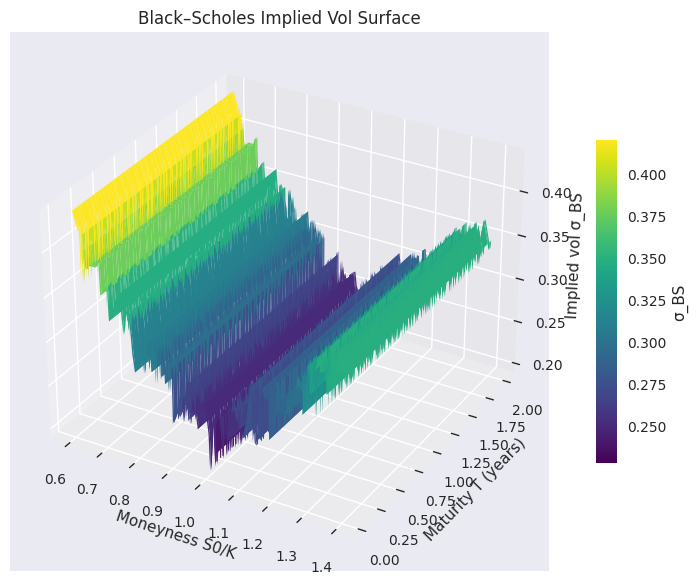

In [21]:
# --- 3D surface: moneyness vs maturity vs implied vol ----------------
T_vals = sigma_surface_m.index.values
M_vals = sigma_surface_m.columns.values
TT, MM = np.meshgrid(T_vals, M_vals, indexing="ij")
ZZ = sigma_surface_m.values

# Replace NaNs with the column mean to keep the surface continuous.
Z_filled = np.array(ZZ, copy=True)
col_means = np.nanmean(Z_filled, axis=0)
inds = np.where(np.isnan(Z_filled))
if inds[0].size > 0:
    Z_filled[inds] = np.take(col_means, inds[1])

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(MM, TT, Z_filled, cmap=cm.viridis, edgecolor="none")
ax.set_title("Black–Scholes Implied Vol Surface")
ax.set_xlabel("Moneyness S0/K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Implied vol σ_BS")
fig.colorbar(surf, shrink=0.6, aspect=15, label="σ_BS")
plt.show()

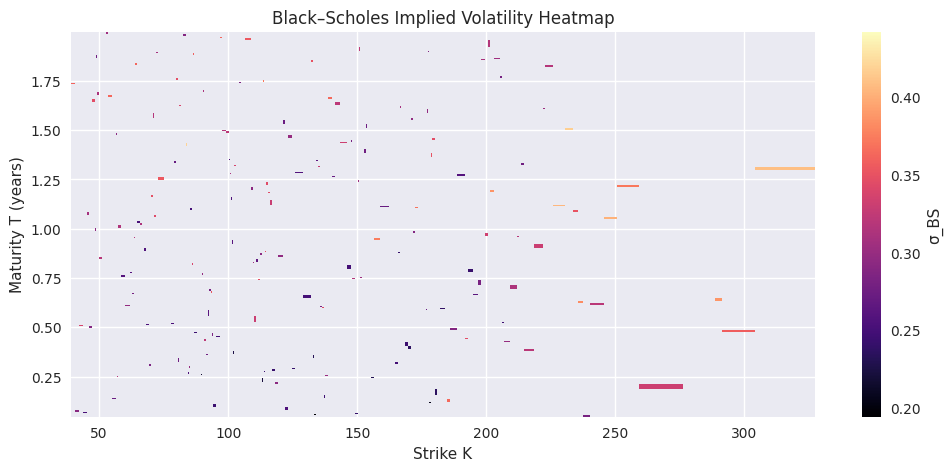

In [22]:
# --- 2D heatmap: strikes vs maturity ---------------------------------
T_vals_k = sigma_surface_k.index.values
K_vals = sigma_surface_k.columns.values
K_mesh, T_mesh = np.meshgrid(K_vals, T_vals_k)
ZK = sigma_surface_k.values

fig, ax = plt.subplots(figsize=(12, 5))
cmap_plot = ax.pcolormesh(K_mesh, T_mesh, ZK, shading="auto", cmap=cm.magma)
ax.set_title("Black–Scholes Implied Volatility Heatmap")
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
fig.colorbar(cmap_plot, ax=ax, label="σ_BS")
plt.show()

## 7. Optional diagnostics

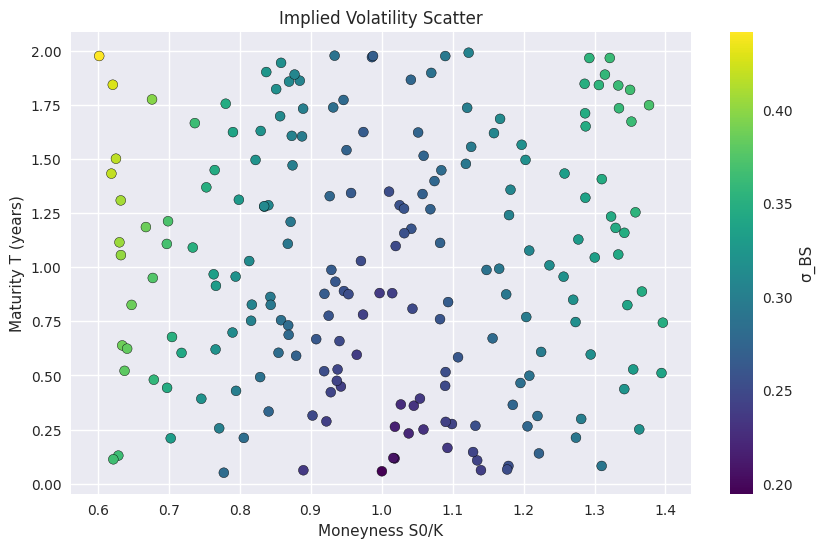

Detected 0 potential σ outliers (3-sigma rule).
No extreme implied vols found.


In [ ]:
# Scatter plot of (moneyness, maturity) colored by implied vol.
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df["moneyness"], df["T"], c=df["sigma_BS"], cmap=cm.viridis, s=50, edgecolor="k")
ax.set_title("Implied Volatility Scatter")
ax.set_xlabel("Moneyness S0/K")
ax.set_ylabel("Maturity T (years)")
fig.colorbar(scatter, ax=ax, label="σ_BS")
plt.show()

# Simple outlier detection based on a symmetric 3-sigma rule.
sigma_mean = df["sigma_BS"].mean()
sigma_std = df["sigma_BS"].std()
upper_cut = sigma_mean + 3 * sigma_std
lower_cut = max(sigma_mean - 3 * sigma_std, 0.0)
outliers = df[(df["sigma_BS"] > upper_cut) | (df["sigma_BS"] < lower_cut)]

print(f"Detected {len(outliers)} potential σ outliers (3-sigma rule).")
if not outliers.empty:
    print(outliers[["S0", "K", "T", "sigma_BS"]].to_string(index=False))
else:
    print("No extreme implied vols found.")



In [26]:
from massive import RESTClient

client = RESTClient("lQ_78z3ZYIkl0ZjcYPnyMH3Q9VM_WfZG")

contracts = []
for c in client.list_options_contracts(
	underlying_ticker="AAPL",
	contract_type="call",
	expiration_date="2026-11-13",
	strike_price=275,
	expired="true",
	order="asc",
	limit=1000,
	sort="ticker",
	):
    contracts.append(c)

print(contracts)

    

[]


## 8. Takeaways
The implied volatility surface above summarises how option prices embed expectations about future variance. Higher moneyness (deep ITM calls) usually compresses σ, while deep OTM regions inflate it; maturity adds term-structure effects where long expiries smooth short-term spikes. Always keep in mind that market noise, sparse strike/maturity grids, and the Black–Scholes framework itself (constant volatility, no jumps) limit the precision of this reconstruction, so further modelling such as local or stochastic volatility is often warranted.